# 台灣縣市人口按性別及五齡組敘述統計分析

本筆記本分析民國 104-113 年台灣各縣市人口統計資料


In [245]:
# 導入所需套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
import warnings
import os
import matplotlib

warnings.filterwarnings('ignore')

# 設定中文字型 - 使用專案內建 Noto Sans TC 字型
print("正在設定中文字型...")
cache_dir = matplotlib.get_cachedir()
print("快取目錄:", cache_dir)

# 刪除 fontlist 快取
for file in os.listdir(cache_dir):
    if "fontlist" in file:
        os.remove(os.path.join(cache_dir, file))
        print("已刪除:", file)
# 載入 Noto Sans TC 字型
noto_font_dir = './fonts/Noto_Sans_TC/static'
if os.path.exists(noto_font_dir):
    # 載入 Regular 和 Bold 字型
    font_files = {
        'Regular': os.path.join(noto_font_dir, 'NotoSansTC-Regular.ttf'),
        'Bold': os.path.join(noto_font_dir, 'NotoSansTC-Bold.ttf'),
        'Medium': os.path.join(noto_font_dir, 'NotoSansTC-Medium.ttf')
    }
    
    loaded_fonts = []
    for weight, font_path in font_files.items():
        if os.path.exists(font_path):
            try:
                font_manager.fontManager.addfont(font_path)
                loaded_fonts.append(weight)
                print(f"✓ 已載入字型: NotoSansTC-{weight}.ttf")
            except Exception as e:
                print(f"✗ 載入 {weight} 失敗: {e}")
    
    if loaded_fonts:
        # 設定使用 Noto Sans TC（只使用專案字型，不回退到系統字型）
        plt.rcParams['font.sans-serif'] = ['Noto Sans TC']
        plt.rcParams['axes.unicode_minus'] = False
        print(f"✓ 字型設定完成: Noto Sans TC ({', '.join(loaded_fonts)})")
    else:
        print("✗ 無法載入任何字型")
else:
    print(f"✗ 找不到字型資料夾: {noto_font_dir}")
    print("請確認 Noto_Sans_TC 資料夾位於 fonts/ 目錄下")

# 設定圖表樣式
sns.set_theme(style='whitegrid', font='Noto Sans TC')
plt.rcParams['figure.figsize'] = (12, 6)

正在設定中文字型...
快取目錄: /Users/yen/.matplotlib
✓ 已載入字型: NotoSansTC-Regular.ttf
✓ 已載入字型: NotoSansTC-Bold.ttf
✓ 已載入字型: NotoSansTC-Medium.ttf
✓ 字型設定完成: Noto Sans TC (Regular, Bold, Medium)


## 1. 資料讀取與清理


## 1. 資料讀取與清理


In [246]:
# 讀取資料
df = pd.read_csv('程式用-縣市人口按性別及五齡組 - 工作表1.csv', encoding='utf-8')

# 顯示原始資料前幾列
print("原始資料前 5 列：")
print(df.head())
print("\n資料形狀：", df.shape)
print("\n欄位名稱：", df.columns.tolist())


原始資料前 5 列：
      區域別   年份           總人口       65～69       70～74      75～79      80～84   \
0   新 北 市   104    3,970,644     164,764     101,225     72,859     45,977    
1   新 北 市   105    3,979,208     192,041     102,640     77,878     46,959    
2   新 北 市   106    3,986,689     213,535     109,568     82,117     49,121    
3   新 北 市   107    3,995,717     232,421     119,084     87,074     51,691    
4   新 北 市   108    4,018,696     247,515     134,166     90,713     55,345    

      85～89      90～94     95～99   100以上        65以下   
0    29,515     11,597     2,650     588     429,175   
1    30,195     12,555     3,086     555     465,909   
2    30,645     13,321     3,497     593     502,397   
3    30,757     14,270     3,769     639     539,705   
4    30,923     15,121     4,021     707     578,511   

資料形狀： (220, 12)

欄位名稱： [' 區域別 ', ' 年份 ', ' 總人口 ', ' 65～69 ', ' 70～74 ', ' 75～79 ', ' 80～84 ', ' 85～89 ', ' 90～94 ', ' 95～99 ', ' 100以上 ', ' 65以下 ']


In [247]:
# 清理欄位名稱（去除空格）
df.columns = df.columns.str.strip()

# 清理資料：移除千分位符號和空格，轉換為數值
numeric_cols = ['總人口', '65～69', '70～74', '75～79', '80～84', '85～89', '90～94', '95～99', '100以上', '65以下']

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '').str.replace(' ', '').astype(float)

# 清理區域別欄位（去除空格）
df['區域別'] = df['區域別'].str.strip()

# 檢視清理後的資料
print("清理後資料前 5 列：")
print(df.head())
print("\n資料型態：")
print(df.dtypes)


清理後資料前 5 列：
     區域別   年份        總人口     65～69     70～74    75～79    80～84    85～89  \
0  新 北 市  104  3970644.0  164764.0  101225.0  72859.0  45977.0  29515.0   
1  新 北 市  105  3979208.0  192041.0  102640.0  77878.0  46959.0  30195.0   
2  新 北 市  106  3986689.0  213535.0  109568.0  82117.0  49121.0  30645.0   
3  新 北 市  107  3995717.0  232421.0  119084.0  87074.0  51691.0  30757.0   
4  新 北 市  108  4018696.0  247515.0  134166.0  90713.0  55345.0  30923.0   

     90～94   95～99  100以上      65以下  
0  11597.0  2650.0  588.0  429175.0  
1  12555.0  3086.0  555.0  465909.0  
2  13321.0  3497.0  593.0  502397.0  
3  14270.0  3769.0  639.0  539705.0  
4  15121.0  4021.0  707.0  578511.0  

資料型態：
區域別       object
年份         int64
總人口      float64
65～69    float64
70～74    float64
75～79    float64
80～84    float64
85～89    float64
90～94    float64
95～99    float64
100以上    float64
65以下     float64
dtype: object


In [248]:
# 計算 65 歲以上總人口
age_cols = ['65～69', '70～74', '75～79', '80～84', '85～89', '90～94', '95～99', '100以上']
df['65歲以上'] = df[age_cols].sum(axis=1)

# 計算老年人口比例
df['老年人口比例(%)'] = (df['65歲以上'] / df['總人口']) * 100

print("加入計算欄位後：")
print(df[['區域別', '年份', '總人口', '65歲以上', '老年人口比例(%)']].head(10))


加入計算欄位後：
     區域別   年份        總人口     65歲以上  老年人口比例(%)
0  新 北 市  104  3970644.0  429175.0  10.808700
1  新 北 市  105  3979208.0  465909.0  11.708586
2  新 北 市  106  3986689.0  502397.0  12.601861
3  新 北 市  107  3995717.0  539705.0  13.507088
4  新 北 市  108  4018696.0  578511.0  14.395490
5  新 北 市  109  4030954.0  618261.0  15.337833
6  新 北 市  110  4008113.0  649938.0  16.215561
7  新 北 市  111  3995551.0  681360.0  17.052967
8  新 北 市  112  4041120.0  728177.0  18.019188
9  新 北 市  113  4047001.0  768492.0  18.989172


## 2. 基本敘述統計


In [249]:
# 總人口的敘述統計
print("=" * 80)
print("總人口敘述統計")
print("=" * 80)
print(df['總人口'].describe())
print("\n標準差：", df['總人口'].std())
print("變異數：", df['總人口'].var())
print("偏度：", df['總人口'].skew())
print("峰度：", df['總人口'].kurtosis())


總人口敘述統計
count    2.200000e+02
mean     1.067350e+06
std      1.098331e+06
min      1.254700e+04
25%      3.257782e+05
50%      5.263465e+05
75%      1.876414e+06
max      4.047001e+06
Name: 總人口, dtype: float64

標準差： 1098331.2884439132
變異數： 1206331619174.8667
偏度： 1.231193914922968
峰度： 0.34750101931442723


In [250]:
# 老年人口比例的敘述統計
print("=" * 80)
print("老年人口比例敘述統計")
print("=" * 80)
print(df['老年人口比例(%)'].describe())
print("\n標準差：", df['老年人口比例(%)'].std())
print("變異數：", df['老年人口比例(%)'].var())
print("偏度：", df['老年人口比例(%)'].skew())
print("峰度：", df['老年人口比例(%)'].kurtosis())


老年人口比例敘述統計
count    220.000000
mean      16.091948
std        2.959701
min        9.670051
25%       14.054708
50%       16.000018
75%       18.307699
max       23.197002
Name: 老年人口比例(%), dtype: float64

標準差： 2.959700818173399
變異數： 8.759828933096289
偏度： -0.018199759470880494
峰度： -0.6307333907337243


In [251]:
# 各年齡層的敘述統計
print("=" * 80)
print("各年齡層敘述統計")
print("=" * 80)
age_stats = df[age_cols].describe()
print(age_stats)


各年齡層敘述統計
               65～69          70～74         75～79         80～84         85～89  \
count     220.000000     220.000000     220.00000    220.000000    220.000000   
mean    61482.336364   41282.286364   27493.70000  19762.572727  11605.018182   
std     66507.965055   45702.828593   26608.96348  17813.676608  10241.906385   
min       486.000000     227.000000     184.00000    150.000000     87.000000   
25%     17304.500000   11295.250000    9061.75000   6259.750000   3936.000000   
50%     29929.000000   20401.000000   15927.50000  12843.000000   7776.000000   
75%     94906.250000   57870.250000   42634.00000  29650.000000  18446.000000   
max    286578.000000  230192.000000  119509.00000  73223.000000  37683.000000   

              90～94        95～99        100以上  
count    220.000000   220.000000   220.000000  
mean    4938.140909  1210.386364   185.440909  
std     4695.546439  1310.127402   235.601690  
min       50.000000    15.000000     1.000000  
25%     1674.250000  

## 3. 按縣市分組的敘述統計


In [252]:
# 各縣市平均人口
print("=" * 80)
print("各縣市平均總人口（104-113 年）")
print("=" * 80)
city_avg_pop = df.groupby('區域別')['總人口'].mean().sort_values(ascending=False)
print(city_avg_pop)


各縣市平均總人口（104-113 年）
區域別
新 北 市    4007369.3
台 中 市    2807315.5
高 雄 市    2759004.5
台 北 市    2600763.1
桃 園 市    2239022.4
台 南 市    1873140.3
彰 化 縣    1264126.4
屏 東 縣     815161.1
雲 林 縣     678119.9
新 竹 縣     567342.3
苗 栗 縣     545455.9
嘉 義 縣     500082.3
南 投 縣     491156.4
宜 蘭 縣     453360.4
新 竹 市     447720.9
基 隆 市     367148.7
花 蓮 縣     324379.3
嘉 義 市     266536.7
台 東 縣     216145.5
金 門 縣     139600.8
澎 湖 縣     105444.2
連 江 縣      13306.3
Name: 總人口, dtype: float64


In [253]:
# 各縣市老年人口比例
print("=" * 80)
print("各縣市平均老年人口比例（104-113 年）")
print("=" * 80)
city_aging = df.groupby('區域別')['老年人口比例(%)'].mean().sort_values(ascending=False)
print(city_aging)


各縣市平均老年人口比例（104-113 年）
區域別
嘉 義 縣    20.108977
雲 林 縣    18.828814
台 北 市    18.693362
南 投 縣    18.343818
屏 東 縣    17.664112
花 蓮 縣    17.189014
台 東 縣    17.162804
基 隆 市    17.099090
宜 蘭 縣    16.992325
澎 湖 縣    16.983821
苗 栗 縣    16.864934
彰 化 縣    16.412393
高 雄 市    16.267586
台 南 市    16.220015
嘉 義 市    15.906646
新 北 市    14.863645
金 門 縣    14.336045
台 中 市    13.319225
新 竹 市    12.854919
新 竹 縣    12.841424
桃 園 市    12.587545
連 江 縣    12.482340
Name: 老年人口比例(%), dtype: float64


In [254]:
# 各縣市總人口統計摘要
print("=" * 80)
print("各縣市總人口統計摘要")
print("=" * 80)
city_summary = df.groupby('區域別')['總人口'].agg([
    ('平均', 'mean'),
    ('中位數', 'median'),
    ('標準差', 'std'),
    ('最小值', 'min'),
    ('最大值', 'max')
]).round(2)
print(city_summary)


各縣市總人口統計摘要
              平均        中位數       標準差        最小值        最大值
區域別                                                        
南 投 縣   491156.4   492472.0  12471.12   472299.0   509490.0
台 中 市  2807315.5  2813974.5  34388.28  2744445.0  2860601.0
台 北 市  2600763.1  2623729.5  90329.06  2480681.0  2704810.0
台 南 市  1873140.3  1877911.5  13289.09  1852997.0  1886522.0
台 東 縣   216145.5   216021.0   4199.05   210219.0   222452.0
嘉 義 市   266536.7   266847.5   3055.08   262177.0   270366.0
嘉 義 縣   500082.3   501297.0  13689.05   478786.0   519839.0
基 隆 市   367148.7   368235.0   4448.66   361441.0   372105.0
宜 蘭 縣   453360.4   453632.5   3490.82   449062.0   458117.0
屏 東 縣   815161.1   815921.0  18001.77   789239.0   841253.0
彰 化 縣  1264126.4  1269736.0  21855.94  1225675.0  1289072.0
新 北 市  4007369.3  4001915.0  26330.79  3970644.0  4047001.0
新 竹 市   447720.9   450107.5   7965.70   434060.0   457242.0
新 竹 縣   567342.3   567354.0  17835.39   542042.0   594641.0
桃 園 市  2239022.4  2258922.0  

## 4. 按年份分組的敘述統計


In [255]:
# 歷年總人口趨勢
print("=" * 80)
print("歷年總人口統計")
print("=" * 80)
year_pop = df.groupby('年份')['總人口'].sum()
print(year_pop)
print("\n人口成長率（相對前一年）：")
pop_growth = year_pop.pct_change() * 100
print(pop_growth)


歷年總人口統計
年份
104    23492074.0
105    23539816.0
106    23571227.0
107    23588932.0
108    23603121.0
109    23561236.0
110    23375314.0
111    23264640.0
112    23420442.0
113    23400220.0
Name: 總人口, dtype: float64

人口成長率（相對前一年）：
年份
104         NaN
105    0.203226
106    0.133438
107    0.075113
108    0.060151
109   -0.177455
110   -0.789101
111   -0.473465
112    0.669694
113   -0.086343
Name: 總人口, dtype: float64


In [256]:
# 歷年老年人口比例趨勢
print("=" * 80)
print("歷年平均老年人口比例")
print("=" * 80)
year_aging = df.groupby('年份')['老年人口比例(%)'].mean()
print(year_aging)


歷年平均老年人口比例
年份
104    13.133657
105    13.738030
106    14.338622
107    14.961412
108    15.639588
109    16.372025
110    17.116317
111    17.783030
112    18.506213
113    19.330584
Name: 老年人口比例(%), dtype: float64


## 5. 視覺化分析


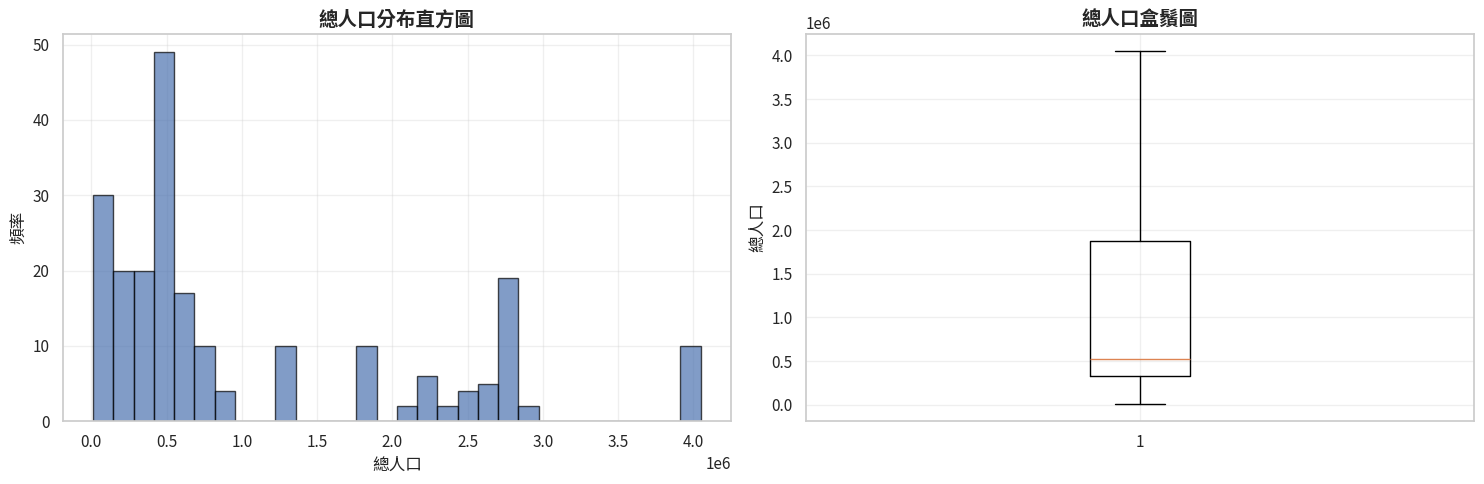

In [257]:
# 總人口分布直方圖和盒鬚圖
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 直方圖
axes[0].hist(df['總人口'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('總人口', fontsize=12)
axes[0].set_ylabel('頻率', fontsize=12)
axes[0].set_title('總人口分布直方圖', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 盒鬚圖
axes[1].boxplot(df['總人口'], vert=True)
axes[1].set_ylabel('總人口', fontsize=12)
axes[1].set_title('總人口盒鬚圖', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


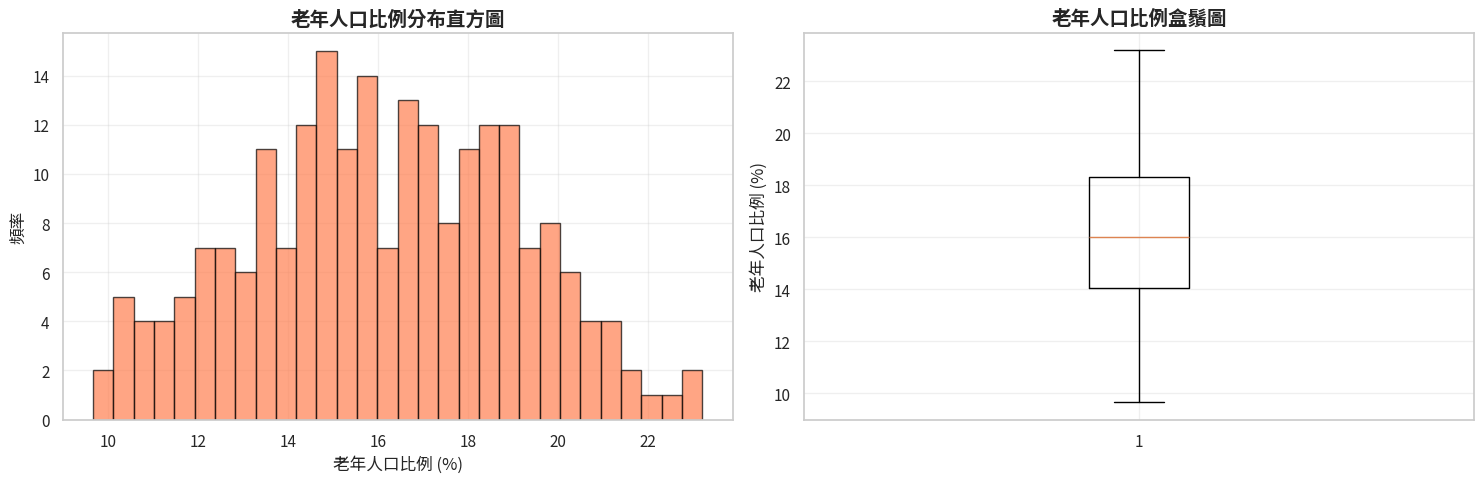

In [258]:
# 老年人口比例分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 直方圖
axes[0].hist(df['老年人口比例(%)'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_xlabel('老年人口比例 (%)', fontsize=12)
axes[0].set_ylabel('頻率', fontsize=12)
axes[0].set_title('老年人口比例分布直方圖', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 盒鬚圖
axes[1].boxplot(df['老年人口比例(%)'], vert=True)
axes[1].set_ylabel('老年人口比例 (%)', fontsize=12)
axes[1].set_title('老年人口比例盒鬚圖', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


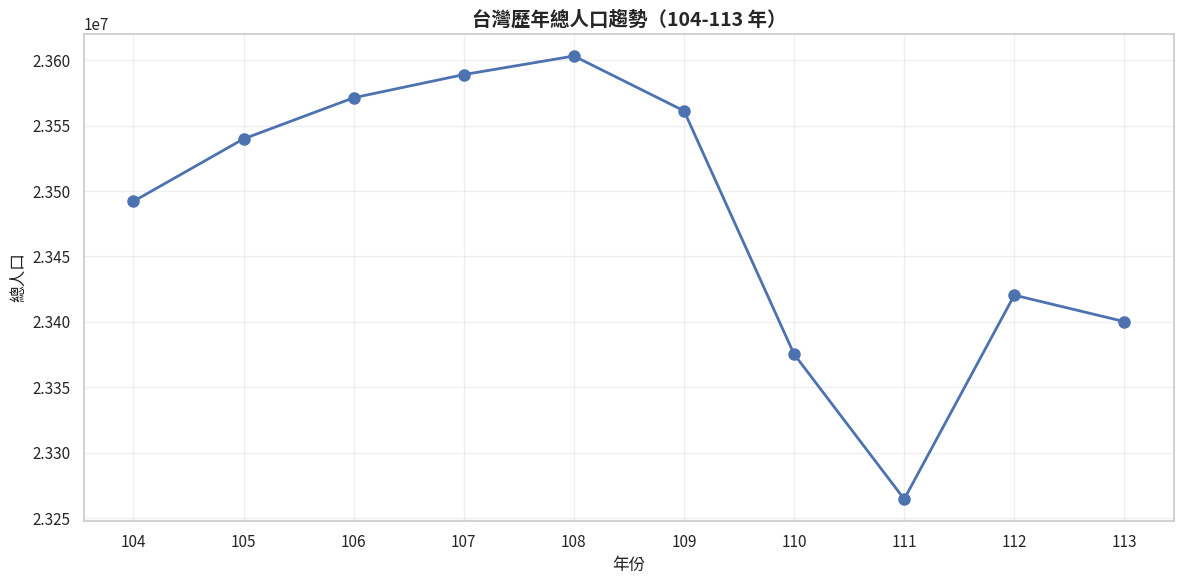

In [259]:
# 歷年總人口趨勢圖
plt.figure(figsize=(12, 6))
year_total = df.groupby('年份')['總人口'].sum()
plt.plot(year_total.index, year_total.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('年份', fontsize=12)
plt.ylabel('總人口', fontsize=12)
plt.title('台灣歷年總人口趨勢（104-113 年）', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(year_total.index)
plt.tight_layout()
plt.show()


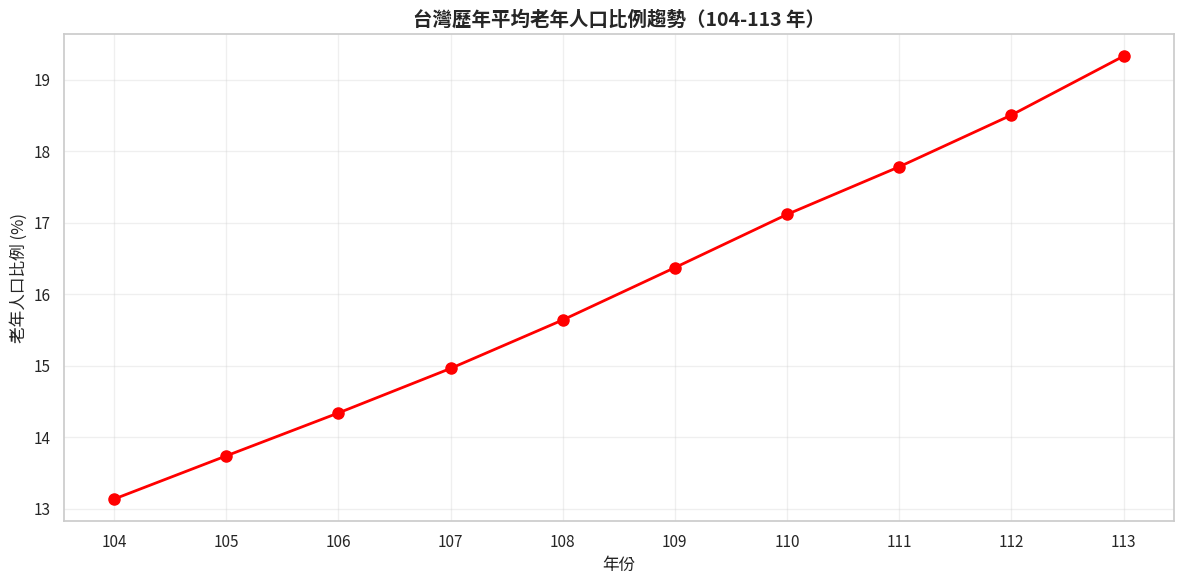

In [260]:
# 歷年老年人口比例趨勢圖
plt.figure(figsize=(12, 6))
year_aging = df.groupby('年份')['老年人口比例(%)'].mean()
plt.plot(year_aging.index, year_aging.values, marker='o', linewidth=2, markersize=8, color='red')
plt.xlabel('年份', fontsize=12)
plt.ylabel('老年人口比例 (%)', fontsize=12)
plt.title('台灣歷年平均老年人口比例趨勢（104-113 年）', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(year_aging.index)
plt.tight_layout()
plt.show()


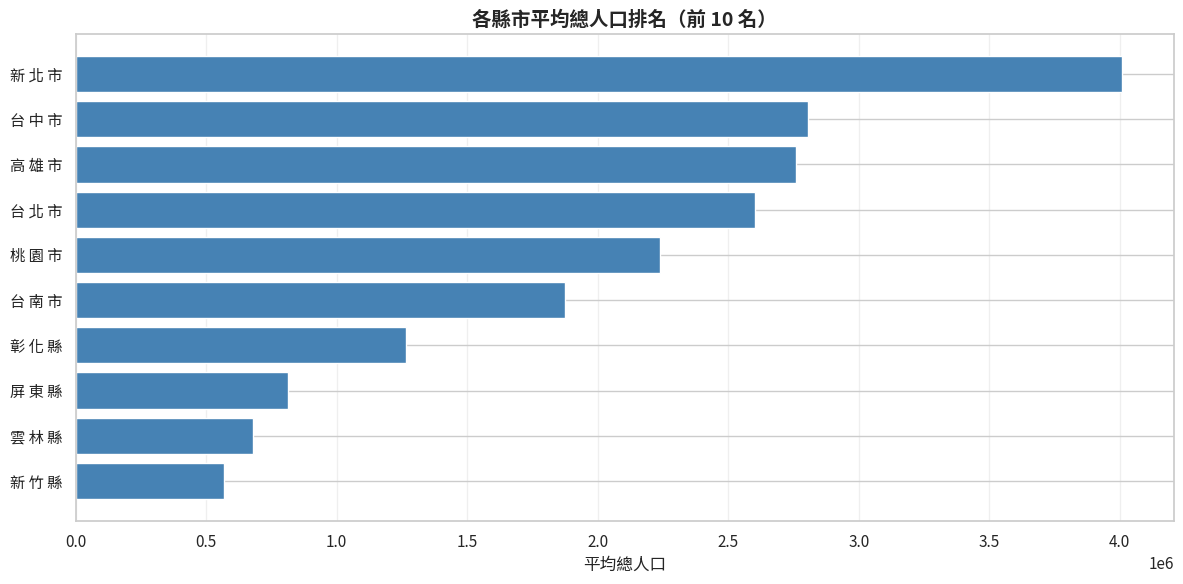

In [261]:
# 各縣市平均總人口排名（前 10 名）
plt.figure(figsize=(12, 6))
top_cities = df.groupby('區域別')['總人口'].mean().sort_values(ascending=False).head(10)
plt.barh(range(len(top_cities)), top_cities.values, color='steelblue')
plt.yticks(range(len(top_cities)), top_cities.index)
plt.xlabel('平均總人口', fontsize=12)
plt.title('各縣市平均總人口排名（前 10 名）', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


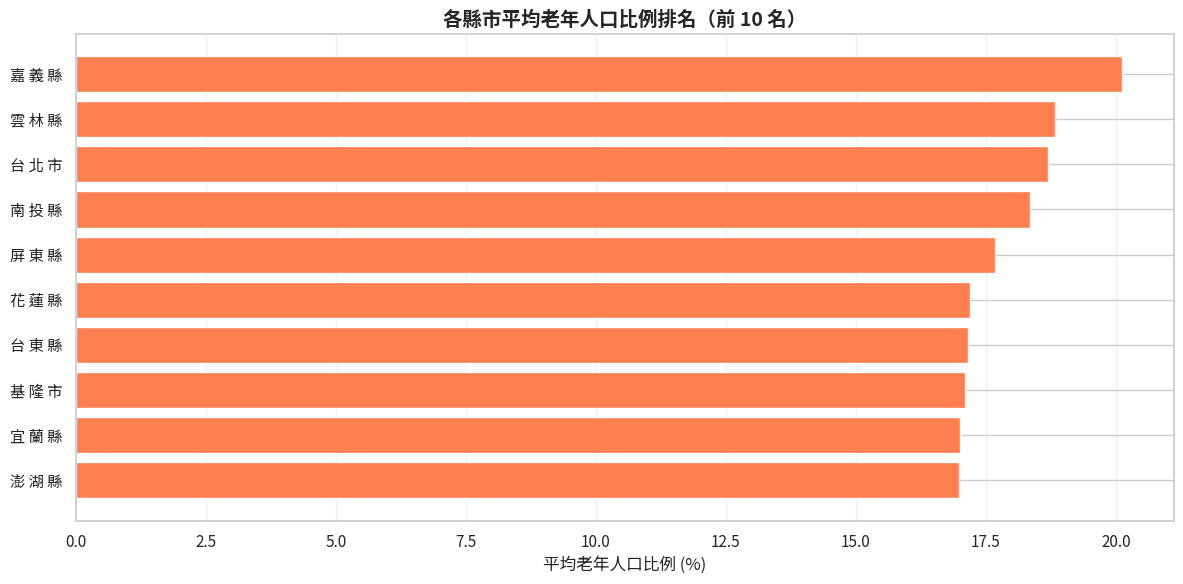

In [262]:
# 各縣市老年人口比例排名（前 10 名）
plt.figure(figsize=(12, 6))
top_aging = df.groupby('區域別')['老年人口比例(%)'].mean().sort_values(ascending=False).head(10)
plt.barh(range(len(top_aging)), top_aging.values, color='coral')
plt.yticks(range(len(top_aging)), top_aging.index)
plt.xlabel('平均老年人口比例 (%)', fontsize=12)
plt.title('各縣市平均老年人口比例排名（前 10 名）', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


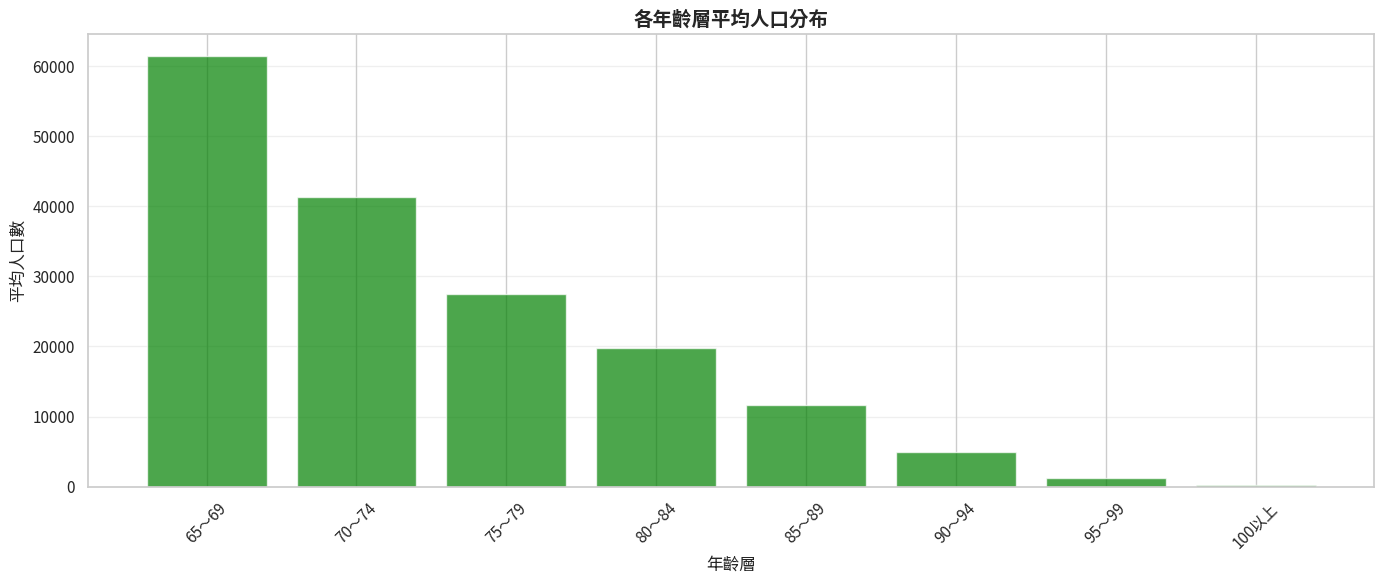

In [263]:
# 各年齡層平均人口分布
plt.figure(figsize=(14, 6))
age_means = df[age_cols].mean().sort_values(ascending=False)
plt.bar(range(len(age_means)), age_means.values, color='green', alpha=0.7)
plt.xticks(range(len(age_means)), age_means.index, rotation=45)
plt.xlabel('年齡層', fontsize=12)
plt.ylabel('平均人口數', fontsize=12)
plt.title('各年齡層平均人口分布', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


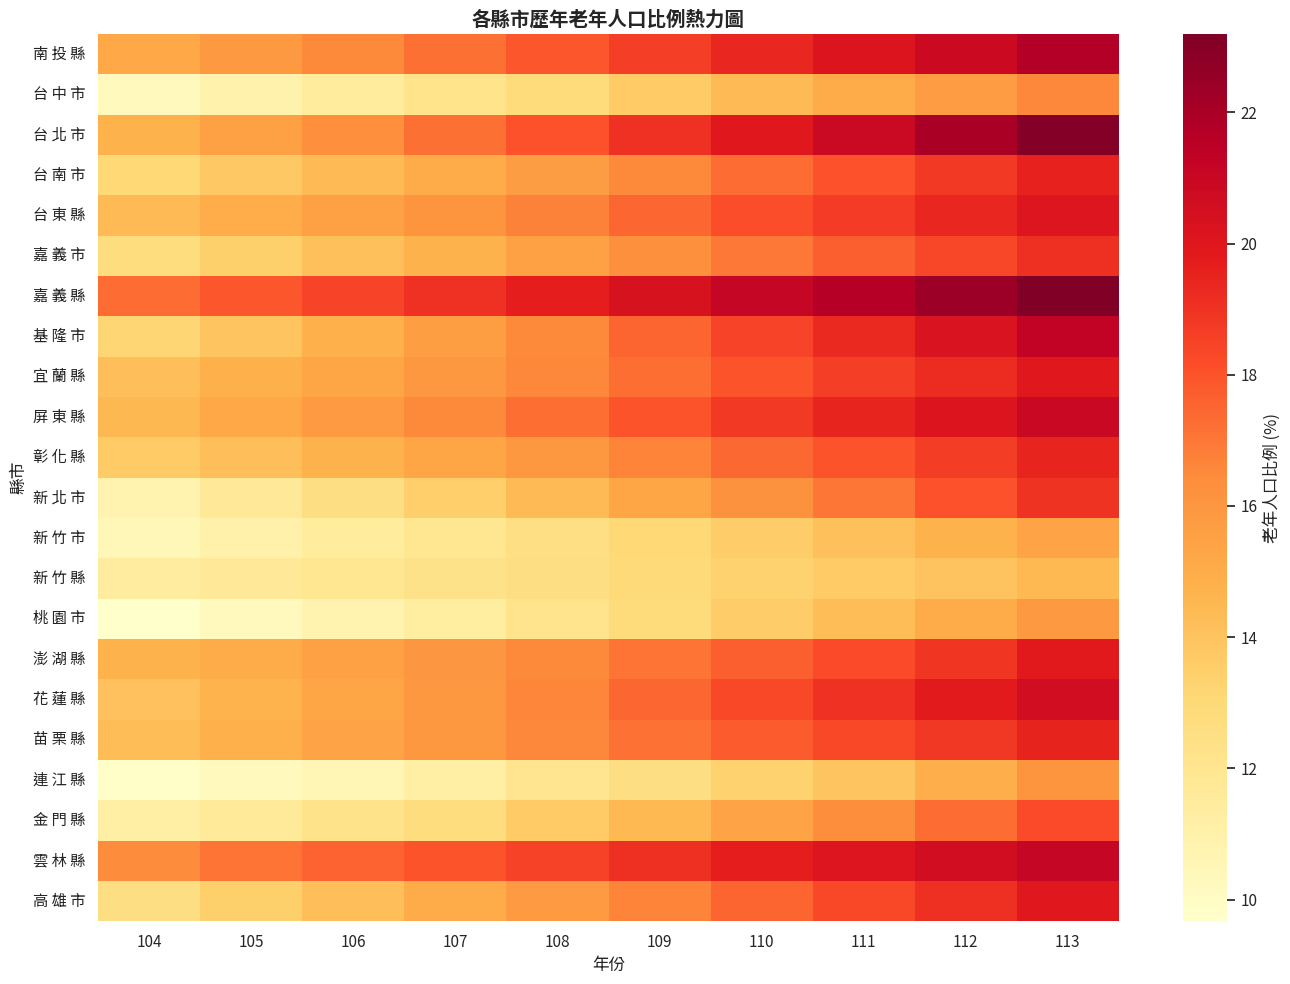

In [264]:
# 熱力圖：各縣市歷年老年人口比例
pivot_aging = df.pivot_table(values='老年人口比例(%)', index='區域別', columns='年份')

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_aging, cmap='YlOrRd', annot=False, fmt='.1f', cbar_kws={'label': '老年人口比例 (%)'})
plt.title('各縣市歷年老年人口比例熱力圖', fontsize=14, fontweight='bold')
plt.xlabel('年份', fontsize=12)
plt.ylabel('縣市', fontsize=12)
plt.tight_layout()
plt.show()


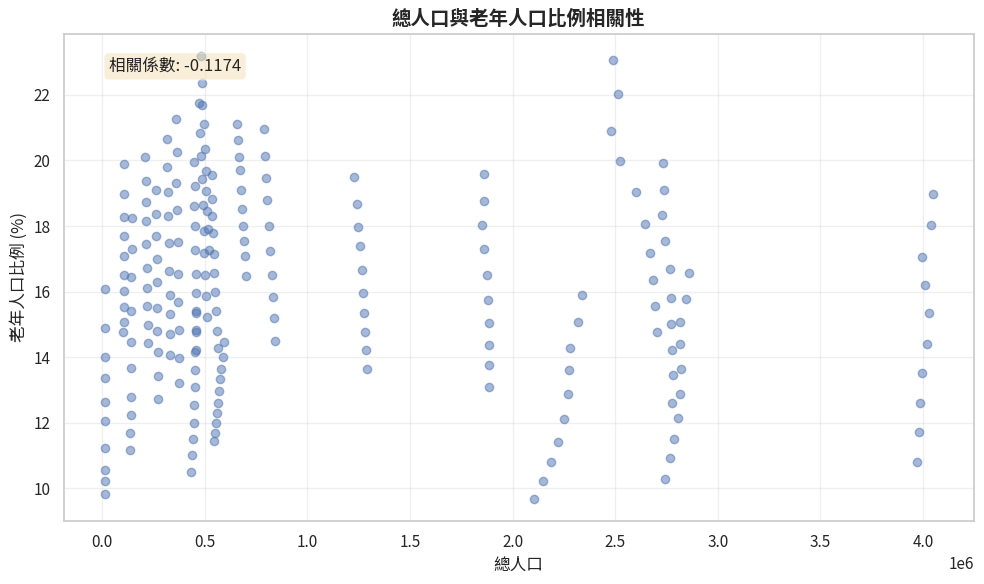

In [265]:
# 相關性分析：總人口與老年人口比例
plt.figure(figsize=(10, 6))
plt.scatter(df['總人口'], df['老年人口比例(%)'], alpha=0.5)
plt.xlabel('總人口', fontsize=12)
plt.ylabel('老年人口比例 (%)', fontsize=12)
plt.title('總人口與老年人口比例相關性', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 計算相關係數
correlation = df['總人口'].corr(df['老年人口比例(%)'])
plt.text(0.05, 0.95, f'相關係數: {correlation:.4f}', 
         transform=plt.gca().transAxes, 
         fontsize=12, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


## 6. 進階統計分析


In [266]:
# 各縣市的變異係數（CV）
print("=" * 80)
print("各縣市總人口變異係數（CV）")
print("=" * 80)
city_cv = df.groupby('區域別')['總人口'].agg(
    lambda x: (x.std() / x.mean()) * 100
).sort_values(ascending=False)
print(city_cv)
print("\n變異係數越大表示該縣市人口變動越劇烈")


各縣市總人口變異係數（CV）
區域別
連 江 縣    4.265018
台 北 市    3.473175
桃 園 市    3.295152
新 竹 縣    3.143673
嘉 義 縣    2.737359
金 門 縣    2.568945
南 投 縣    2.539134
屏 東 縣    2.208369
雲 林 縣    2.178460
苗 栗 縣    1.985439
台 東 縣    1.942698
澎 湖 縣    1.818457
花 蓮 縣    1.802493
新 竹 市    1.779166
彰 化 縣    1.728936
台 中 市    1.224952
基 隆 市    1.211677
嘉 義 市    1.146213
宜 蘭 縣    0.769988
高 雄 市    0.759823
台 南 市    0.709455
新 北 市    0.657059
Name: 總人口, dtype: float64

變異係數越大表示該縣市人口變動越劇烈


各年齡層相關性矩陣
              65～69     70～74     75～79     80～84     85～89     90～94  \
65～69      1.000000  0.977383  0.981810  0.972369  0.952810  0.952898   
70～74      0.977383  1.000000  0.965161  0.966124  0.934920  0.937128   
75～79      0.981810  0.965161  1.000000  0.991147  0.981500  0.964205   
80～84      0.972369  0.966124  0.991147  1.000000  0.989964  0.974854   
85～89      0.952810  0.934920  0.981500  0.989964  1.000000  0.984167   
90～94      0.952898  0.937128  0.964205  0.974854  0.984167  1.000000   
95～99      0.932621  0.939719  0.933899  0.941378  0.941459  0.979241   
100以上      0.883698  0.895994  0.883512  0.881148  0.882212  0.933026   
總人口        0.974487  0.926399  0.967510  0.949580  0.944757  0.926071   
老年人口比例(%)  0.030097  0.127982  0.038703  0.098875  0.081735  0.109993   

              95～99     100以上       總人口  老年人口比例(%)  
65～69      0.932621  0.883698  0.974487   0.030097  
70～74      0.939719  0.895994  0.926399   0.127982  
75～79      0.933899  0.8835

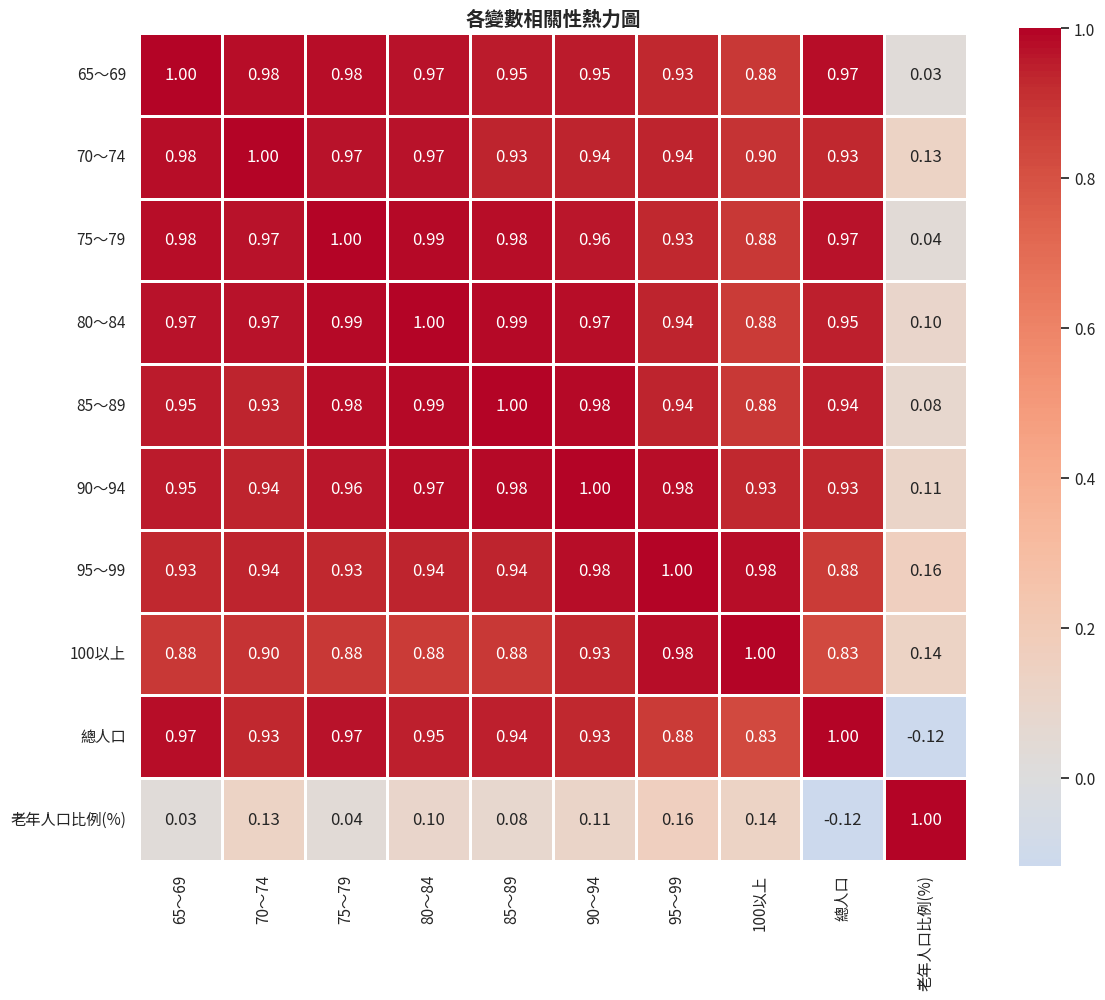

In [267]:
# 相關性矩陣
print("=" * 80)
print("各年齡層相關性矩陣")
print("=" * 80)
correlation_matrix = df[age_cols + ['總人口', '老年人口比例(%)']].corr()
print(correlation_matrix)

# 繪製相關性熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('各變數相關性熱力圖', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [268]:
# 四分位數分析
print("=" * 80)
print("總人口四分位數分析")
print("=" * 80)
q1 = df['總人口'].quantile(0.25)
q2 = df['總人口'].quantile(0.50)
q3 = df['總人口'].quantile(0.75)
iqr = q3 - q1

print(f"第一四分位數 (Q1): {q1:,.0f}")
print(f"第二四分位數 (Q2/中位數): {q2:,.0f}")
print(f"第三四分位數 (Q3): {q3:,.0f}")
print(f"四分位距 (IQR): {iqr:,.0f}")
print(f"下界 (Q1 - 1.5*IQR): {q1 - 1.5*iqr:,.0f}")
print(f"上界 (Q3 + 1.5*IQR): {q3 + 1.5*iqr:,.0f}")

# 找出離群值
outliers = df[(df['總人口'] < q1 - 1.5*iqr) | (df['總人口'] > q3 + 1.5*iqr)]
print(f"\n離群值數量: {len(outliers)}")
if len(outliers) > 0:
    print("\n離群值資料：")
    print(outliers[['區域別', '年份', '總人口']].sort_values('總人口', ascending=False))


總人口四分位數分析
第一四分位數 (Q1): 325,778
第二四分位數 (Q2/中位數): 526,346
第三四分位數 (Q3): 1,876,414
四分位距 (IQR): 1,550,636
下界 (Q1 - 1.5*IQR): -2,000,176
上界 (Q3 + 1.5*IQR): 4,202,368

離群值數量: 0


## 7. 結論摘要


In [269]:
print("=" * 80)
print("敘述統計分析結論摘要")
print("=" * 80)

# 總體統計
print("\n【整體概況】")
print(f"資料筆數: {len(df)} 筆")
print(f"縣市數量: {df['區域別'].nunique()} 個")
print(f"年份範圍: {df['年份'].min()} - {df['年份'].max()} 年")
print(f"平均總人口: {df['總人口'].mean():,.0f} 人")
print(f"平均老年人口比例: {df['老年人口比例(%)'].mean():.2f}%")

# 最大最小
print("\n【極值分析】")
max_pop_row = df.loc[df['總人口'].idxmax()]
min_pop_row = df.loc[df['總人口'].idxmin()]
print(f"最大人口: {max_pop_row['區域別']} ({max_pop_row['年份']}年) - {max_pop_row['總人口']:,.0f} 人")
print(f"最小人口: {min_pop_row['區域別']} ({min_pop_row['年份']}年) - {min_pop_row['總人口']:,.0f} 人")

max_aging_row = df.loc[df['老年人口比例(%)'].idxmax()]
min_aging_row = df.loc[df['老年人口比例(%)'].idxmin()]
print(f"最高老化率: {max_aging_row['區域別']} ({max_aging_row['年份']}年) - {max_aging_row['老年人口比例(%)']:.2f}%")
print(f"最低老化率: {min_aging_row['區域別']} ({min_aging_row['年份']}年) - {min_aging_row['老年人口比例(%)']:.2f}%")

# 趨勢
print("\n【趨勢分析】")
pop_104 = df[df['年份'] == 104]['總人口'].sum()
pop_113 = df[df['年份'] == 113]['總人口'].sum()
pop_change = ((pop_113 - pop_104) / pop_104) * 100
print(f"104年總人口: {pop_104:,.0f} 人")
print(f"113年總人口: {pop_113:,.0f} 人")
print(f"人口變化率: {pop_change:+.2f}%")

aging_104 = df[df['年份'] == 104]['老年人口比例(%)'].mean()
aging_113 = df[df['年份'] == 113]['老年人口比例(%)'].mean()
aging_change = aging_113 - aging_104
print(f"104年平均老化率: {aging_104:.2f}%")
print(f"113年平均老化率: {aging_113:.2f}%")
print(f"老化率增加: {aging_change:+.2f} 個百分點")

print("\n" + "=" * 80)


敘述統計分析結論摘要

【整體概況】
資料筆數: 220 筆
縣市數量: 22 個
年份範圍: 104 - 113 年
平均總人口: 1,067,350 人
平均老年人口比例: 16.09%

【極值分析】
最大人口: 新 北 市 (113年) - 4,047,001 人
最小人口: 連 江 縣 (104年) - 12,547 人
最高老化率: 嘉 義 縣 (113年) - 23.20%
最低老化率: 桃 園 市 (104年) - 9.67%

【趨勢分析】
104年總人口: 23,492,074 人
113年總人口: 23,400,220 人
人口變化率: -0.39%
104年平均老化率: 13.13%
113年平均老化率: 19.33%
老化率增加: +6.20 個百分點

